# 🛠 1. Modularized Code

## 1.1. MSA Reading and Contact Inference (light)



In [1]:
import numpy as np
import itertools
from sklearn.linear_model import LogisticRegression


def infer_contacts_from_msa(msa_path, top_k=30, pseudocount=1.0, method='mi'):
    """
    Infere pares de contato a partir de alinhamento MSA
    Suporte a dois métodos: 'mi' (Mutual Information), 'dca' (Direct Coupling Analysis simplificado)
    """
    sequences = []
    with open(msa_path, 'r') as f:
        seq = ''
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if seq:
                    sequences.append(seq)
                    seq = ''
            else:
                seq += line
        if seq:
            sequences.append(seq)

    if len(sequences) == 0:
        raise ValueError(f"MSA vazio ou inválido: {msa_path}")

    n = len(sequences[0])
    num_seqs = len(sequences)
    alphabet = 'ACGU'
    mapping = {nt: i for i, nt in enumerate(alphabet)}
    num_nt = len(alphabet)

    # Frequências com pseudocontagem
    freq = np.zeros((n, num_nt)) + pseudocount
    for seq in sequences:
        for i, nt in enumerate(seq):
            if nt in mapping:
                freq[i, mapping[nt]] += 1
    freq /= freq.sum(axis=1, keepdims=True)

    if method == 'mi':
        MI = np.zeros((n, n))
        for i, j in itertools.combinations(range(n), 2):
            joint = np.zeros((num_nt, num_nt)) + pseudocount
            for seq in sequences:
                if seq[i] in mapping and seq[j] in mapping:
                    joint[mapping[seq[i]], mapping[seq[j]]] += 1
            joint /= joint.sum()
            pi = freq[i]
            pj = freq[j]
            pij = joint
            with np.errstate(divide='ignore', invalid='ignore'):
                mi = pij * np.log2(pij / (pi[:, None] * pj[None, :]))
                mi = np.nan_to_num(mi)
            MI[i, j] = MI[j, i] = np.sum(mi)
        score_matrix = MI

    elif method == 'dca':
        # Flattened one-hot encoding
        X = np.zeros((num_seqs, n * num_nt))
        for s_idx, seq in enumerate(sequences):
            for i, nt in enumerate(seq):
                if nt in mapping:
                    X[s_idx, i * num_nt + mapping[nt]] = 1

        # Fit pseudo-inverse covariance model
        C = np.cov(X, rowvar=False)
        try:
            inv_C = np.linalg.pinv(C)
        except np.linalg.LinAlgError:
            inv_C = np.eye(C.shape[0])

        # DCA score is Frobenius norm of off-diagonal blocks
        DCA = np.zeros((n, n))
        for i, j in itertools.combinations(range(n), 2):
            block = inv_C[i * num_nt:(i + 1) * num_nt, j * num_nt:(j + 1) * num_nt]
            DCA[i, j] = DCA[j, i] = np.linalg.norm(block)
        score_matrix = DCA

    else:
        raise ValueError("Método inválido. Use 'mi' ou 'dca'")

    # Seleção dos top_k pares
    contact_pairs = np.dstack(np.unravel_index(np.argsort(score_matrix.ravel())[::-1], (n, n)))[0]
    contacts = []
    seen = set()
    for i, j in contact_pairs:
        if abs(i - j) > 3 and (i, j) not in seen and (j, i) not in seen:
            contacts.append((i, j))
            seen.add((i, j))
        if len(contacts) >= top_k:
            break

    return contacts

## 1.2. Contact-Based Structure Generation



In [2]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import random


def generate_rna_structure_with_contacts(
    sequence: str,
    contacts: list[tuple[int, int]],
    noise_level: float = 0.2,
    ideal_distance: float = 8.0,
    iterations: int = 10
) -> np.ndarray:
    """
    Gera uma estrutura 3D para uma sequência de RNA, refinando posições com base em contatos inferidos.

    Args:
        sequence (str): Sequência de RNA (ex: 'ACGU...')
        contacts (List[Tuple[int, int]]): Lista de pares de nucleotídeos em contato (índices base 0)
        noise_level (float): Nível de ruído gaussiano adicionado ao caminho inicial
        ideal_distance (float): Distância ideal entre pares de contato (em Ångstrons)
        iterations (int): Número de iterações de refinamento dos contatos

    Returns:
        np.ndarray: Array (n, 3) com coordenadas 3D dos nucleotídeos
    """
    n = len(sequence)
    coords = np.zeros((n, 3))
    step = 4.0
    current_dir = np.array([1.0, 0.0, 0.0])

    coords[0] = np.array([0.0, 0.0, 0.0])
    for i in range(1, n):
        angle = random.uniform(-0.15, 0.15)
        axis = np.random.normal(0, 1, 3)
        axis /= np.linalg.norm(axis)
        rot = R.from_rotvec(angle * axis)
        current_dir = rot.apply(current_dir)
        coords[i] = coords[i - 1] + step * current_dir + np.random.normal(0, noise_level, 3)

    for _ in range(iterations):
        for i, j in contacts:
            if not (0 <= i < n and 0 <= j < n):
                continue
            vec = coords[j] - coords[i]
            dist = np.linalg.norm(vec)
            if dist > 1e-5:
                correction = 0.5 * (dist - ideal_distance) * vec / dist
                coords[i] += correction
                coords[j] -= correction

    return coords


## 1.3. Generate 5 Different Structures


In [3]:
def generate_five_structures(sequence, contacts):
    structures = []
    for _ in range(5):
        # Generate a structure with a random noise level between 0.1 and 0.3
        coords = generate_rna_structure_with_contacts(sequence, contacts, noise_level=random.uniform(0.1, 0.3))
        structures.append(coords)  # Store the generated coordinates
    return structures  # Return the list of 5 structures


## 1.4. Save for Submission

In [4]:
import pandas as pd

def create_submission(target_ids, sequences, msa_folder, output_file="submission.csv"):
    submission = []

    # Loop over each target sequence
    for target_id, sequence in zip(target_ids, sequences):
        msa_path = f"{msa_folder}/{target_id}.MSA.fasta"  # Path to MSA file
        contacts = infer_contacts_from_msa(msa_path)  # Infer contacts from MSA

        structures = generate_five_structures(sequence, contacts)  # Generate five predicted structures

        # For each nucleotide in the sequence
        for idx, nuc in enumerate(sequence):
            row = {
                'ID': f'{target_id}_{idx+1}',     # Unique ID for each nucleotide
                'resname': nuc,                   # Nucleotide base (A, C, G, U)
                'resid': idx + 1                  # Residue index (1-based)
            }
            # Save coordinates from each of the 5 models
            for m in range(5):
                row[f'x_{m+1}'] = structures[m][idx, 0]
                row[f'y_{m+1}'] = structures[m][idx, 1]
                row[f'z_{m+1}'] = structures[m][idx, 2]
            submission.append(row)  # Add row to the submission list

    # Create a DataFrame
    submission_df = pd.DataFrame(submission)

    # Ensure the submission file has the correct format
    column_order = ['ID', 'resname', 'resid']
    for i in range(1, 6):
        for coord in ['x', 'y', 'z']:
            column_order.append(f'{coord}_{i}')
    
    submission_df = submission_df[column_order]

    # Save the submission file
    submission_df.to_csv(output_file, index=False)
    print(f"Saved submission to {output_file}")
    print(f"Generated predictions for {len(sequences)} RNA sequences")
    
    return submission_df.head()


## 1.5. Visualizing Structures


In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_structure(coords, sequence):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

    # Extract x, y, z coordinates
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
    nucleotides = sequence

    # Define colors for each nucleotide type
    color_map = {'A': 'red', 'C': 'blue', 'G': 'green', 'U': 'orange'}
    colors = [color_map.get(nuc, 'gray') for nuc in nucleotides]  # Default to gray if unknown

    # Plot nucleotides as colored points
    ax.scatter(x, y, z, c=colors, s=40)
    # Connect the points with lines
    ax.plot(x, y, z, color='black', alpha=0.6)

    # Annotate each nucleotide with its letter
    for i, nuc in enumerate(nucleotides):
        ax.text(x[i], y[i], z[i], nuc, size=8, color='black')

    # Set plot title and axis labels
    ax.set_title('Predicted RNA Structure')
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')

    # Set the view angle
    ax.view_init(elev=30, azim=120)
    
    # Display the plot
    plt.show()


## 1.5 Return and capture

In [6]:
import pandas as pd

# Load the test sequences file
test_seqs = pd.read_csv('/kaggle/input/stanford-rna-3d-folding/test_sequences.csv')

# Define the path where the MSAs are located
msa_folder = "/kaggle/input/stanford-rna-3d-folding/MSA"

# Extract target IDs and sequences from the DataFrame
target_ids = test_seqs['target_id'].tolist()
sequences = test_seqs['sequence'].tolist()

# Generate submission file
create_submission(target_ids, sequences, msa_folder=msa_folder, output_file="submission.csv")


Saved submission to submission.csv
Generated predictions for 12 RNA sequences


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,R1107_1,G,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,R1107_2,G,2,3.995624,0.610142,-0.282326,4.058700,-0.096629,0.016837,3.971083,-0.036924,-0.016515,4.311069,-0.965178,0.419684,4.166372,0.130611,0.333095
2,R1107_3,G,3,8.076521,1.053827,-0.521337,8.067699,-0.297699,0.213260,8.005914,-0.474514,-0.539176,8.820440,-1.598419,0.267081,7.950303,-0.099826,0.753820
3,R1107_4,G,4,12.152319,1.196383,-0.776356,12.034505,-0.408720,0.551328,12.178264,-0.772557,-0.562321,13.261142,-2.360474,0.318277,11.853472,-0.428115,0.794153
4,R1107_5,G,5,122.890551,-28.691118,-49.948574,120.181210,47.284932,43.623439,134.075698,-36.017435,25.223275,141.712279,-18.798007,12.596639,137.983270,14.983680,0.919477


## 1.7 Alignment of structures via kabsch

In [7]:
import numpy as np

def kabsch(P, Q, return_rotation=False):
    """
    Aligns coordinates P to Q using the Kabsch algorithm (no scaling).
    Returns aligned P and optionally the rotation matrix.
    """
    P = np.asarray(P, dtype=np.float64)
    Q = np.asarray(Q, dtype=np.float64)
    P_centroid = P.mean(axis=0)
    Q_centroid = Q.mean(axis=0)

    P_centered = P - P_centroid
    Q_centered = Q - Q_centroid

    H = P_centered.T @ Q_centered
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    if np.linalg.det(R) < 0:
        Vt[-1] *= -1
        R = Vt.T @ U.T

    P_aligned = P_centered @ R + Q_centroid

    return (P_aligned, R) if return_rotation else P_aligned


def calculate_tm_score(coords1, coords2):
    """
    Computes TM-score-like metric between two 3D structures.
    """
    coords1 = np.asarray(coords1, dtype=np.float64)
    coords2 = np.asarray(coords2, dtype=np.float64)
    assert coords1.shape == coords2.shape, "Coordinate sets must have the same shape."

    n = coords1.shape[0]
    aligned = kabsch(coords1, coords2)

    dist2 = np.sum((aligned - coords2)**2, axis=1)

    d0 = max(0.6 * np.sqrt(n - 0.5) - 2.5, 0.5)
    score = np.mean(1 / (1 + dist2 / d0**2))
    return score


## 1.8 Visualization and Tm-score


✅ Best TM-score found: 0.526


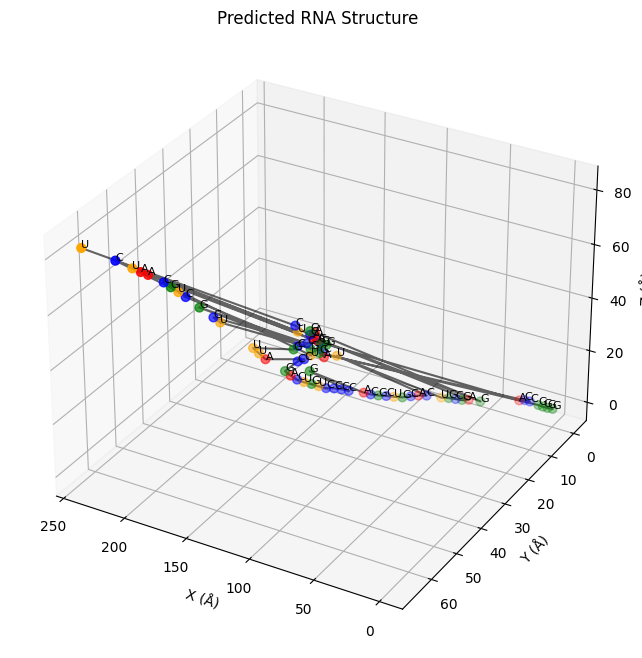

In [8]:
# Infer contacts from the MSA file for the first target
contacts = infer_contacts_from_msa(f"{msa_folder}/{target_ids[0]}.MSA.fasta")

best_tm_score = 0.0
best_predicted_structure = None

# Loop até encontrar TM-score > 0.5
while best_tm_score <= 0.5:
    # Gera cinco estruturas com base nos contatos
    structures = generate_five_structures(sequences[0], contacts)
    
    # Calcula o TM-score para cada estrutura gerada
    for i in range(len(structures)):
        for j in range(i + 1, len(structures)):
            predicted_structure = structures[i]
            reference_structure = structures[j]
            
            tm_score = calculate_tm_score(predicted_structure, reference_structure)
            
            if tm_score > best_tm_score:
                best_tm_score = tm_score
                best_predicted_structure = predicted_structure

# Quando terminar o loop
print(f"\n✅ Best TM-score found: {best_tm_score:.3f}")

# Visualiza a melhor estrutura
visualize_structure(best_predicted_structure, sequences[0])
